In [1]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("token")

# from huggingface_hub import login

# login(secret_value_0)

In [2]:
!pip install sentencepiece datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12

In [3]:
import locale
import os
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

## 1. Dataset

#### Load the dataset

In [4]:
import torch
import sentencepiece
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets
import numpy as np 
import sacrebleu

2025-06-09 10:57:16.670493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749466636.847920      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749466636.904095      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
RANDOM_SEED = 42

with open('/kaggle/input/train-eng-bdq-phase2dataset-v1/bdq-eng.train.bdq', 'r', encoding='utf-8') as file_ba:
    ba_data = file_ba.readlines()
with open('/kaggle/input/train-eng-bdq-phase2dataset-v1/bdq-eng.train.eng', 'r', encoding='utf-8') as file_en:
    en_data = file_en.readlines()
assert len(ba_data) == len(en_data), "The files don't have the same number of lines."
train_df = pd.DataFrame({'English': en_data, 'Bahnar': ba_data})
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)
#No val_df since no validation whatsoever 

ba_en_train_dataset = Dataset.from_pandas(train_df)
# ba_en_val_dataset = Dataset.from_pandas(val_df)

with open('/kaggle/input/test-eng-bdq-phase2dataset-v1/bdq-eng.test.bdq', 'r', encoding='utf-8') as file_ba:
    ba_data = file_ba.readlines()
with open('/kaggle/input/test-eng-bdq-phase2dataset-v1/bdq-eng.test.eng', 'r', encoding='utf-8') as file_en:
    en_data = file_en.readlines()
assert len(ba_data) == len(en_data), "The files don't have the same number of lines."
test_df = pd.DataFrame({'English': en_data, 'Bahnar': ba_data})
ba_en_test_dataset = Dataset.from_pandas(test_df)

print(len(ba_en_train_dataset), len(ba_en_test_dataset))

24224 1000


In [6]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [7]:
# tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = NllbTokenizer.from_pretrained('/kaggle/input/checkpoint-nllb/transformers/default/2')

In [8]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [9]:
from datasets import concatenate_datasets
full_dataset = concatenate_datasets([ba_en_train_dataset, ba_en_test_dataset])
len(full_dataset)

25224

#### Check NLLB tokenizer for unknown tokens

In [10]:
import random
from datasets import Dataset
from nltk.tokenize import word_tokenize
import pandas as pd

# Step 1: Sample 10,000 examples
sampled = full_dataset

# Step 2: Apply subword tokenizer
def tokenize_example(example):
    return {
        'en_toks': tokenizer.tokenize(example['English']),
        'ba_toks': tokenizer.tokenize(example['Bahnar']),
        'en_words': word_tokenize(example['English']),
        'ba_words': word_tokenize(example['Bahnar'])
    }

tokenized_dataset = sampled.map(tokenize_example)

# Step 3: Convert to pandas for stats
df = tokenized_dataset.to_pandas()

# Step 4: Compute length stats
stats = df[['en_toks', 'ba_toks', 'en_words', 'ba_words']].map(len).describe()

# Step 5: Print token/word ratios
print(stats.en_toks['mean'] / stats.en_words['mean'])
print(stats.ba_toks['mean'] / stats.ba_words['mean'])

# Step 6: Print tokenizer UNK info
print(tokenizer.unk_token, tokenizer.unk_token_id)

Map:   0%|          | 0/25224 [00:00<?, ? examples/s]

1.1708776865933022
2.205711089306838
<unk> 3


In [11]:
stats

,en_toks,ba_toks,en_words,ba_words
count,25224.000000,25224.000000,25224.000000,25224.000000
mean,23.988463,47.679789,20.487591,21.616516
std,15.552951,30.325284,13.363663,13.869221
min,1.000000,0.000000,1.000000,0.000000
25%,11.000000,23.000000,9.000000,10.000000
50%,20.000000,40.000000,17.000000,18.000000
75%,34.000000,67.000000,29.000000,30.000000
max,105.000000,276.000000,91.000000,103.000000


In [12]:
# Find texts with UNK tokens in Bahnar field
bahnar_texts = df['Bahnar'].tolist()
texts_with_unk = [text for text in tqdm(bahnar_texts) if tokenizer.unk_token_id in tokenizer(text).input_ids]

# Show count and sample
print(len(texts_with_unk))
print(random.sample(texts_with_unk, 5))

  0%|          | 0/25224 [00:00<?, ?it/s]

1514
["Thoi noh Kră Yang Tih Hloh 'Bok Kei-Dei lu bơngai Isơrael khan: “'Nâu Inh gô 'me rong kon pơlei 'nâu hăm 'long tăng păng ăn kơ lu sư nhă đak hơkăm bơnhŭl\n", '“Mưh lu kon pơlei đĭch đam ih tơblah hăm lu ayăt, kiơ̆ kơ đơ̆ng Ih wơh; mưh sư krao khan hơdrĭ hăm anăn ih; sư tơwih gah pơlei âu pơlei mă Ih rơih bơih, sư tơkan tơ hnam akŭm mă đơ̆ng inh pơm\n', "Lu sư teh pơpuh lu aseh mă lu pơtao đe Juđa pơyơ̆r ăn kơ yang măt 'năr, pơdơ̆ng 'bơ̆t 'măng mơ̆t tơ Hnam akŭm kơkuh kơ Kră Yang, jê̆ hnam linh krĕo anăn sư Nathan Mêlek, 'bơ̆t cham Hnam akŭm,’ Jôsia soh rŭk lê̆ đĭ lu gre aseh pơyơ̆r kơ yang măt 'năr\n", "Na Yêsu tơblang ăn kơ lu sư: “Bơngai mă rei adrĕch 'ba 'lơ̆ng noh wă khan Inh Kon Bơngai\n", "“Đĭ rim 'nu kon bơngai gô đei tơdrong gleh pơmat-tat\n"]


#### Fix encoding to fix unknown tokens

In [13]:

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer

# --- Normalization Setup ---
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [(re.compile(r), sub) for r, sub in mpn.substitutions]

def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line: str) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

# Custom character normalization for problematic characters
def custom_char_normalizer(text: str) -> str:
    # Replace problematic accented characters with their base versions or remove them
    text = text.replace("Ĭ", "I").replace("Ŭ", "U").replace("Ŏ", "O")
    text = text.replace("Ĭ", "I").replace("Ŭ", "U").replace("Ĕ", "E")
    # Add more characters here as needed
    return text


def preproc(text: str) -> str:
    text = custom_char_normalizer(text)
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

# --- Texts with UNKs (after normalization) ---
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print("Texts with UNKs (after normalization):", len(texts_with_unk_normed))

  0%|          | 0/1514 [00:00<?, ?it/s]

Texts with UNKs (after normalization): 0


In [14]:
# sample_text = random.choice(texts_with_unk_normed)
sample_text = random.choice(bahnar_texts)

preprocessed = preproc(sample_text)

# Tokenize and get IDs
encoding = tokenizer(preprocessed, return_tensors=None)
tokens =  tokenizer.tokenize(preproc(sample_text))
ids = encoding.input_ids

# Identify tokens that are UNK
unk_tokens = [tok for tok, id_ in zip(tokens, ids) if id_ == tokenizer.unk_token_id]

# Print output
print("Original:", sample_text)
print("Preprocessed:", preprocessed)
print("All Tokens:", tokens)
print("UNK Tokens:", unk_tokens)
print("Tokens:", encoding.input_ids)

Original: Sư iŏk pơđĭ lu rup yang anhăk ba tơ dêh char Êyiptơ, hăm iŏk pơđĭ lu rup man păng đĭ lu maih păng đĭ lu pơnhan chhĕr pơm păng hu păng maih hai; dang 'bar pêng sơnăm sư ưh kơ blah pơtao yă-nơ̆m

Preprocessed: Sư iŏk pơđĭ lu rup yang anhăk ba tơ dêh char Êyiptơ, hăm iŏk pơđĭ lu rup man păng đĭ lu maih păng đĭ lu pơnhan chhĕr pơm păng hu păng maih hai; dang 'bar pêng sơnăm sư ưh kơ blah pơtao yă-nơ̆m
All Tokens: ['▁S', 'ư', '▁i', 'ŏ', 'k', '▁p', 'ơ', 'đ', 'ĭ', '▁lu', '▁rup', '▁yang', '▁anh', 'ă', 'k', '▁ba', '▁t', 'ơ', '▁dê', 'h', '▁char', '▁Ê', 'yi', 'pt', 'ơ', ',', '▁h', 'ăm', '▁i', 'ŏ', 'k', '▁p', 'ơ', 'đ', 'ĭ', '▁lu', '▁rup', '▁man', '▁p', 'ăng', '▁đ', 'ĭ', '▁lu', '▁mai', 'h', '▁p', 'ăng', '▁đ', 'ĭ', '▁lu', '▁p', 'ơn', 'han', '▁chh', 'ĕ', 'r', '▁p', 'ơ', 'm', '▁p', 'ăng', '▁hu', '▁p', 'ăng', '▁mai', 'h', '▁hai', ';', '▁dang', "▁'", 'bar', '▁pê', 'ng', '▁s', 'ơn', 'ăm', '▁sư', '▁', 'ư', 'h', '▁k', 'ơ', '▁blah', '▁p', 'ơ', 'tao', '▁y', 'ă', '-', 'n', 'ơ', '̆', 'm']
UNK Tokens:

In [15]:
tokenizer.convert_ids_to_tokens(encoding.input_ids)

['eng_Latn',
 '▁S',
 'ư',
 '▁i',
 'ŏ',
 'k',
 '▁p',
 'ơ',
 'đ',
 'ĭ',
 '▁lu',
 '▁rup',
 '▁yang',
 '▁anh',
 'ă',
 'k',
 '▁ba',
 '▁t',
 'ơ',
 '▁dê',
 'h',
 '▁char',
 '▁Ê',
 'yi',
 'pt',
 'ơ',
 ',',
 '▁h',
 'ăm',
 '▁i',
 'ŏ',
 'k',
 '▁p',
 'ơ',
 'đ',
 'ĭ',
 '▁lu',
 '▁rup',
 '▁man',
 '▁p',
 'ăng',
 '▁đ',
 'ĭ',
 '▁lu',
 '▁mai',
 'h',
 '▁p',
 'ăng',
 '▁đ',
 'ĭ',
 '▁lu',
 '▁p',
 'ơn',
 'han',
 '▁chh',
 'ĕ',
 'r',
 '▁p',
 'ơ',
 'm',
 '▁p',
 'ăng',
 '▁hu',
 '▁p',
 'ăng',
 '▁mai',
 'h',
 '▁hai',
 ';',
 '▁dang',
 "▁'",
 'bar',
 '▁pê',
 'ng',
 '▁s',
 'ơn',
 'ăm',
 '▁sư',
 '▁',
 'ư',
 'h',
 '▁k',
 'ơ',
 '▁blah',
 '▁p',
 'ơ',
 'tao',
 '▁y',
 'ă',
 '-',
 'n',
 'ơ',
 '̆',
 'm',
 '</s>']

#### Add new language tag

In [16]:
# from transformers import AutoModelForSeq2SeqLM
# from transformers import NllbTokenizer

# tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))


In [17]:
# def fix_tokenizer(tokenizer, new_lang='bah_Latn'):
#     tokenizer.add_special_tokens({"additional_special_tokens": [new_lang]}, replace_additional_special_tokens=False)

# fix_tokenizer(tokenizer)

In [18]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) 
# WTF why mask is not last token ?

256205
['zul_Latn', '<mask>', 'bah_Latn']


In [19]:
added_token_id = tokenizer.convert_tokens_to_ids('bah_Latn')
similar_lang_id = tokenizer.convert_tokens_to_ids('vie_Latn')
print(added_token_id, similar_lang_id)

256204 256193


## 2. Model

#### Initialize Model and Training args

In [20]:
# model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
# model.resize_token_embeddings(len(tokenizer))

# # initializing new language token with a token of a similar language
# model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

In [21]:
model = AutoModelForSeq2SeqLM.from_pretrained('/kaggle/input/checkpoint-nllb/transformers/default/2')

In [22]:

import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

torch.cuda.empty_cache()

model.cuda()

optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [23]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 50000 #Less steps

In [24]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

#### Batch pairs

Pairs of sentences and language role (source-target) from the base training En-Ba dataset are randomly selected. 

In [25]:
import random

LANGS = [('English', 'eng_Latn'), ('Bahnar', 'bah_Latn')]

def get_batch_pairs(batch_size, data):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []

    # Sample batch_size random indices
    indices = random.sample(range(len(data)), batch_size)

    for idx in indices:
        item = data[idx]  # Hugging Face Dataset

        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))

    return xx, yy, long1, long2
print(get_batch_pairs(1, data = ba_en_train_dataset))

(["Ơ Kră Yang 'Bok Kei-Dei, Ih trŏ boih kơ nhôn hli kơkuh lăm anih 'lơ̆ng rơgoh"], ['O God, thou art terrible out of thy holy places:'], 'bah_Latn', 'eng_Latn')


### Training

In [26]:
MODEL_SAVE_PATH = './nllb-bah-eng-v1'

In [ ]:
optimizer.load_state_dict(torch.load('/kaggle/input/checkpoint-nllb/transformers/default/2/optimizer.pt'))
scheduler.load_state_dict(torch.load('/kaggle/input/checkpoint-nllb/transformers/default/2/scheduler.pt'))
### Comment to start training

In [ ]:

model.train()
x, y, loss = None, None, None
torch.cuda.empty_cache()
current_step = 40000 ### Set at 0 to start training

tq = trange(current_step, training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size, data = ba_en_train_dataset)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        torch.cuda.empty_cache()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)
        torch.save(optimizer.state_dict(), os.path.join(MODEL_SAVE_PATH, 'optimizer.pt'))
        torch.save(scheduler.state_dict(), os.path.join(MODEL_SAVE_PATH, 'scheduler.pt'))

/tmp/ipykernel_19/130940138.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer.load_state_dict(torch.load('/kaggle/input/checkpoint-nllb/transformers/default/2/op

  0%|          | 0/10000 [00:00<?, ?it/s]

40000 0.2238229513168335
41000 0.19313714187592268
42000 0.18391387128457426
43000 0.17346845465525984
44000 0.17098603210784494
45000 0.1659120639152825
46000 0.15987090903893114
47000 0.15264386088773607
48000 0.1457504816353321
49000 0.14082217466458677


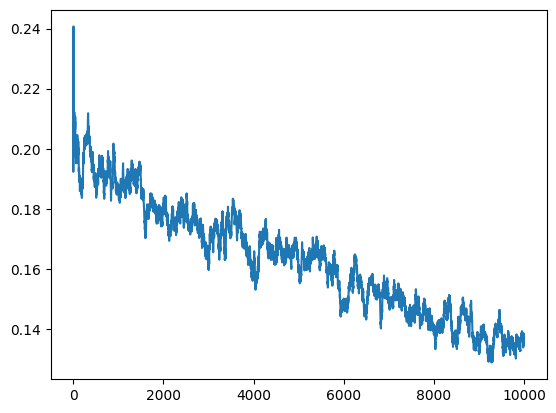

In [29]:
pd.Series(losses).ewm(100).mean().plot();

## 3. Testing

In [30]:
#We only have one tokenizer so no need to care
def translate(text, model, src_lang='bah_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=512, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [31]:
import torch
from tqdm.auto import tqdm

def evaluate_model(model, dataset):
    model.eval()
    prt = True

    predictions, references = [], []
    for example in tqdm(dataset, desc="Translating"):
        # with encode_tokenizer.as_target_tokenizer():
        #     input_ids = encode_tokenizer.encode(example['Bahnar'], return_tensors='pt').to(device)

        # output_ids = model.generate(input_ids)[0]
        # pred = decode_tokenizer.decode(output_ids, skip_special_tokens=True)
        pred = translate(example['Bahnar'], model)
        predictions.append(pred)

        references.append([example['English']])

    return predictions, references

test_examples = [{'Bahnar': ex['Bahnar'], 'English': ex['English']} for ex in ba_en_test_dataset]
predictions, references = evaluate_model(model, test_examples)

Translating:   0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
predictions[0], references[0] # Check format of predictions and references

(["I'll leave but I can't help you"], ['I release you, but can do no more.\n'])

In [33]:
len(predictions), len(references)

(1000, 1000)

In [34]:
preds = []
refs = []
for pred in predictions:
    preds.append(pred[0])

for ref in references:
    refs.append(ref)

print(refs[:2])
print(preds[:2])

[['I release you, but can do no more.\n'], ['You have as much right to be a knight as any man.\n']]
["I'll leave but I can't help you", 'Thou art more mighty than none:']


In [35]:
# preds = [_[0] for _ in preds]
# refs = [_[0] for _ in refs]

# Calculate and print the BLEU score
bleu = sacrebleu.corpus_bleu(preds, refs)
print("BLEU: ", round(bleu.score, 2))

# Calculate CHRF
chrf = sacrebleu.corpus_chrf(preds, refs)
print("CHRF:", round(chrf.score, 2))

# Calculate TER
metric = sacrebleu.metrics.TER()
ter = metric.corpus_score(preds, refs)
print("TER:", round(ter.score, 2))

# wandb.log({"BLEU": round(bleu.score, 2), "CHRF": round(chrf.score, 2), "TER": round(ter.score, 2)})

BLEU:  20.56
CHRF: 38.17
TER: 36.37


In [36]:
# Display the first 3 prediction-reference pairs
for i in range(11,20):
    print(f"Prediction {i+1}: {predictions[i][0]}")
    print(f"Reference {i+1}: {references[i][0]}")

Prediction 12: Take the shield, and the bow that thou canst find
Reference 12: Get all the weapons and ammo you can.

Prediction 13: My daughter's never heard of it
Reference 13: My daughter will get over it.

Prediction 14: And their office was under full command by the hand of Herodias, at the commandment of Herodias
Reference 14: - Chancellor Angela Merkel, during a news conference with President Putin.

Prediction 15: And Hosane Rahman, keeper of the jawbone, thou knowest how to pronounce him ruler
Reference 15: And Hosain Rahman, the CEO of Aliph Jawbone, you know, really understands that you need a different structure.

Prediction 16: And the decree shall be, that the accursed thing should be brought unto him for ever: even unto the plague and to the stroke shall he be brought unto the end
Reference 16: The court order to seize organization property owned by Jehovah's Witnesses adds insult to injury.

Prediction 17: you did find it already
Reference 17: You've already found him.


In [37]:
translate("Sư âu Peter Griffin, mă-lei sư ăch pơm.", model, src_lang='bah_Latn', tgt_lang='eng_Latn')

["He's Peter Grifin, but he did it"]

In [ ]:
        # model.save_pretrained(MODEL_SAVE_PATH)
        # tokenizer.save_pretrained(MODEL_SAVE_PATH)
        # torch.save(optimizer.state_dict(), os.path.join(MODEL_SAVE_PATH, 'optimizer.pt'))
        # torch.save(scheduler.state_dict(), os.path.join(MODEL_SAVE_PATH, 'scheduler.pt'))